# 단순선형회귀분석

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap

In [2]:
DATA_PATH = '../DATA/'
data = nc.Dataset(DATA_PATH + '/T2m_ERA5_1979_2018_lowR.nc', 'r')

In [3]:
lon = data.variables['lon'][:]  # Lon
lat = data.variables['lat'][:]  # Lat
time = data.variables['time'][:]  # Time
T2m = data.variables['t2m'][:, :, :]  # T2m data
print("lon = 경도(가로)\nlat = 위도\ntime = 시간\nT2 = 평균온도")
data.close()

lon = 경도(가로)
lat = 위도
time = 시간
T2 = 평균온도


In [4]:
print(f" lat {lat.shape}\n lon {lon.shape}\n time {time.shape}\n T2m {T2m.shape}")

 lat (30,)
 lon (60,)
 time (40,)
 T2m (40, 30, 60)


# cosin array

In [5]:
cosarray = np.zeros((len(lat), len(lon)))
RAD = np.pi/180.
for x in range(0, len(lat)):
    cosarray[x, :] = np.cos(lat[x]*RAD)

# Weigted avarage of T2M

In [6]:
wgt_T2m_year0 = np.zeros(T2m.shape)
for t in range(0, len(T2m)):
    wgt_T2m_year0[t, :, :] = T2m[t, :, :]*cosarray

kelvin_temp = 273.15
wgt_T2m_year = np.sum(wgt_T2m_year0, 2)
avg_T2m_year = np.sum(wgt_T2m_year, 1)/np.sum(cosarray) - kelvin_temp

# Regression analysis

In [7]:
x = np.arange(1979, 2018+1)
r = stats.linregress(x, avg_T2m_year)
beta = r.slope
alpha = r.intercept
y = (beta * x) + alpha

In [8]:
r = stats.linregress(x, avg_T2m_year)
r

LinregressResult(slope=0.014412505081224637, intercept=-14.0622601738952, rvalue=0.8400852599257234, pvalue=1.2196912199064701e-11, stderr=0.0015096891432682053)

In [9]:
beta = r.slope
alpha = r.intercept
y = (beta * x) + alpha

# Surface temp trend

In [10]:
T2m_trend = np.zeros((len(lat), len(lon)))
T2m_sig = np.zeros((len(lat), len(lon)))
years = np.arange(1979, 1979+len(time))

for i in range(len(lat)):
    for j in range(len(lon)):
        t2 = T2m[:, i, j]
        r = stats.linregress(years, t2)
        # trend
        T2m_trend[i, j] = r.slope*len(time)  # 베타(r.slope)에 40년치
        if r.pvalue < 0.05:  # 95% 유의 수준
            T2m_sig[i, j] = 1
        else:
            T2m_sig[i, j] = np.NaN

t2m_trend_sig = T2m_trend*T2m_sig
levels = np.arange(-2.25, 2.5, 0.25)

# plot (95%significance level)

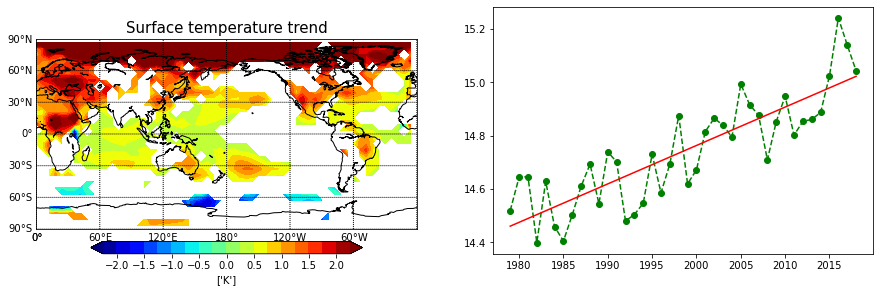

In [11]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(221)
ax.set_title('Surface temperature trend', fontsize=15)
m = Basemap(projection='cyl', resolution='c', llcrnrlat=-
            90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)
m.drawparallels(np.arange(-90, 120, 30), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(60, 420, 60), labels=[0, 0, 0, 1])
m.drawcoastlines()
draw = plt.contourf(lon, lat, t2m_trend_sig, levels, cmap='jet', extend='both')
plt.colorbar(draw, orientation='horizontal',
             fraction=0.05, pad=0.05, label=['K'])

ax = fig.add_subplot(222)
plt.plot(x, avg_T2m_year, 'go--', x, y, 'r')